<a href="https://colab.research.google.com/github/dailyLi/yelp_da/blob/main/Yelp_word_cloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
import pandas as pd
import numpy as np
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.svm import LinearSVC

from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
data = pd.read_csv('drive/My Drive/Colab Notebooks/Yelp_sentiment/train.csv', names= ('class','text'))

In [6]:
data["text"]

0         Unfortunately, the frustration of being Dr. Go...
1         Been going to Dr. Goldberg for over 10 years. ...
2         I don't know what Dr. Goldberg was like before...
3         I'm writing this review to give you a heads up...
4         All the food is great here. But the best thing...
                                ...                        
559995    Ryan was as good as everyone on yelp has claim...
559996    Professional \nFriendly\nOn time AND affordabl...
559997    Phone calls always go to voicemail and message...
559998    Looks like all of the good reviews have gone t...
559999    Ryan Rocks! I called him this morning for some...
Name: text, Length: 560000, dtype: object

In [7]:
stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer()

## Preprocessing
Takes in a df to performs the cleaning:
- Lower capital letters
- Remove all punctuation
- Reduce words to their word stem
- Return a list of words

In [26]:
def text_process(data):
   
    for i in range(len(data)):
        line = data[i]
        line = line.lower()
        translation = str.maketrans("","", string.punctuation);
        line = line.translate(translation)
        split = word_tokenize(line)
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        filtered = []
        for token in split:
            if re.search('[a-zA-Z]', token):    
                filtered.append(token)
        
        # filter out stop words
        word = [i for i in filtered if i not in stopwords.words('english')]
        word = [i for i in filtered if i not in STOPWORDS]
        
        d = [stemmer.stem(word) for word in word] 
        d = [wordnet_lemmatizer.lemmatize(word) for word in d]
        data[i] = d
    return data

## Word cloud

In [29]:
def top_words(text_df):
    train = list(text_df)
    text = text_process(train)
    text = sum(text,[])
    
    counts = Counter(text)
    wordcloud = WordCloud(    
                          background_color='white',
                          max_words=100,
                          max_font_size=50,
                          min_font_size=10,
                          random_state=40,
                        
                         ).fit_words(counts)
    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [27]:
negative = data['text'][data['class'] == 1].head(10000)

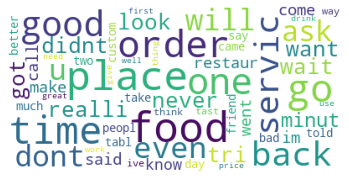

In [28]:
top_words(negative)

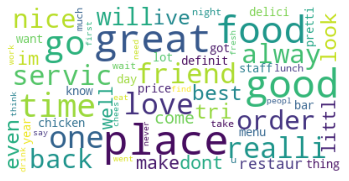

In [30]:
positive = data['text'][data['class'] == 2].head(10000)
top_words(positive)

## Importance features extraction

In [ ]:
def onegram(business_id):
    
    train  = sample[sample['business_id'] == business_id][review_ml['True(1)/Deceptive(0)'] == 'True']
    train_data =  list(train['Review'])    # text
    label = list(train['Stars'])           # ratings
    train_label = change_label(label)
    
    text = text_process(train_data)
    text = sum(text,[])
    text = set(text)
    text = list(text)
    transformer = TfidfVectorizer() 
    cvectorizer = transformer.fit(text)
    transformed = cvectorizer.transform(train['Review'])  
#     print(cvectorizer.get_feature_names())

    # SVM
    clf = LinearSVC()
    clf.fit(transformed,train_label)
    
    coefficients = clf.coef_.ravel()
    pos_coefficients = np.argsort(coefficients )[-10:]
    neg_coefficients = np.argsort(coefficients )[:10]
    combine = np.hstack([neg_coefficients, pos_coefficients])
    
    plt.figure(figsize=(7, 4))
    colors = ['red' if i < 0 else 'blue' for i in coefficients[combine]]
    plt.bar(np.arange(2 * 10), coefficients[combine], color=colors)
    feature_names = np.array(cvectorizer.get_feature_names())
    
    plt.title('why the restaurant is rated as bad or good ', fontsize = 15)
    plt.xticks(np.arange( 0, 2 * 10), feature_names[combine], rotation=40, ha='right')
    plt.show()